In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features
import matplotlib.pyplot as plt

In [2]:
from scipy import signal
from scipy.signal import find_peaks, peak_widths

In [3]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data

#indexes = 0nose, 1L-ear, 2R-ear, 3L-shoulder, 4R-shoulder, 5L-elbow, 6R-elbow, 7L-wrist, 
# 8R-wrist, 9L-hip, 10R-hip, 11L-knee, 12R-knee, 13L-ankle, 14R-ankle

In [4]:
breakdataid = pd.DataFrame(dataFM['Break'], columns=['pose', 'id'])
breakdata = breakdataid['pose']

housedataid = pd.DataFrame(dataFM['House'], columns=['pose', 'id'])
housedata = housedataid['pose']

popdataid = pd.DataFrame(dataFM['Pop'], columns=['pose', 'id'])
popdata = popdataid['pose']

krumpdataid = pd.DataFrame(dataFM['Krump'], columns=['pose', 'id'])
krumpdata = krumpdataid['pose']


print(breakdata[0].shape, housedata[0].shape, popdata[0].shape, krumpdata[0].shape)

(15, 2302, 3) (15, 1919, 3) (15, 1771, 3) (15, 1919, 3)


In [5]:
breakdataid.head()

,pose,id
0,"[[[-37.2453321280263, 164.81916088945948, -7.4...",gBR_sFM_cAll_d05_mBR2_ch09
1,"[[[-28.104818974028607, 170.73762056099753, 19...",gBR_sFM_cAll_d04_mBR5_ch06
2,"[[[-9.474825950224703, 196.02542995262422, 0.2...",gBR_sFM_cAll_d06_mBR2_ch16
3,"[[[-7.053650571821774, 211.45426304109083, 17....",gBR_sFM_cAll_d04_mBR3_ch04
4,"[[[-34.06971385193801, 143.944929665691, -15.7...",gBR_sFM_cAll_d04_mBR2_ch03


In [6]:
#do the above cell but in a loop all at once
idx = 8
breakhousepopkrump = []

for dance in (breakdata[idx], housedata[idx], popdata[idx], krumpdata[idx]):
    dance1 = Dance(dance, 1/60)
    dance1.get_movedata()
    danceaccel = dance1.movedata[2]
    dance1.get_sacrum()
    breakhousepopkrump.append(dance1)
    
break1 = breakhousepopkrump[0]
house1 = breakhousepopkrump[1]
pop1 = breakhousepopkrump[2]
krump1 = breakhousepopkrump[3]
print(break1.pos.shape, house1.pos.shape, pop1.pos.shape, krump1.pos.shape)

(15, 1919, 3) (15, 1706, 3) (15, 2093, 3) (15, 2093, 3)


In [7]:
# #calculate angular momentum for the break, house, pop, krump dances
# angmombr = np.empty_like(break1.pos[0])
# angmomho = np.empty_like(house1.pos[0])
# angmompo = np.empty_like(pop1.pos[0])
# angmomkr = np.empty_like(krump1.pos[0])

# for frame in range(len(break1.pos[0])):
#     for j in range(len(break1.pos)):
#         angmombr[frame] = np.cross(break1.pos[j][frame] - break1.sacrum[0][frame], break1.velocity[j][frame])
#         angmomho[frame] = np.cross(house1.pos[j][frame] - house1.sacrum[0][frame], house1.velocity[j][frame])
#         angmompo[frame] = np.cross(pop1.pos[j][frame] - pop1.sacrum[0][frame], pop1.velocity[j][frame])
#         angmomkr[frame] = np.cross(krump1.pos[j][frame] - krump1.sacrum[0][frame], krump1.velocity[j][frame])

        


In [8]:
angmombr = np.empty_like(break1.pos[0])

for f in range(break1.numframes):
        for j in range(len(break1.pos)):
            angmombr[f] = np.cross(break1.pos[j][f] - break1.sacrum[0][f], break1.velocity[j][f])
angmombrmean = angmombr.mean()

angmomho = np.empty_like(house1.pos[0])

for f in range(house1.numframes):
        for j in range(len(house1.pos)):
            angmomho[f] = np.cross(house1.pos[j][f] - house1.sacrum[0][f], house1.velocity[j][f])
angmomhomean = angmomho.mean()

angmompo = np.empty_like(pop1.pos[0])

for f in range(pop1.numframes):
        for j in range(len(pop1.pos)):
            angmompo[f] = np.cross(pop1.pos[j][f] - pop1.sacrum[0][f], pop1.velocity[j][f])
angmompomean = angmompo.mean()

angmomkr = np.empty_like(krump1.pos[0])

for f in range(krump1.numframes):
        for j in range(len(krump1.pos)):
            angmomkr[f] = np.cross(krump1.pos[j][f] - krump1.sacrum[0][f], krump1.velocity[j][f])
angmomkrmean = angmomkr.mean()


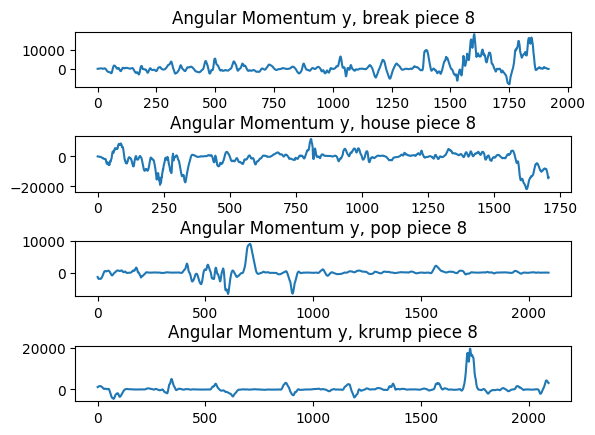

In [9]:
#plot angular momentum, summed across dimensions for a break, house, pop, and krump piece. Four separate figures
fig, ax = plt.subplots(4, 1)
ax[0].plot(angmombr[:,1])
ax[0].set_title('Angular Momentum y, break piece 8')
ax[1].plot(angmomho[:,1])
ax[1].set_title('Angular Momentum y, house piece 8')
ax[2].plot(angmompo[:,1])
ax[2].set_title('Angular Momentum y, pop piece 8')
ax[3].plot(angmomkr[:,1])
ax[3].set_title('Angular Momentum y, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()


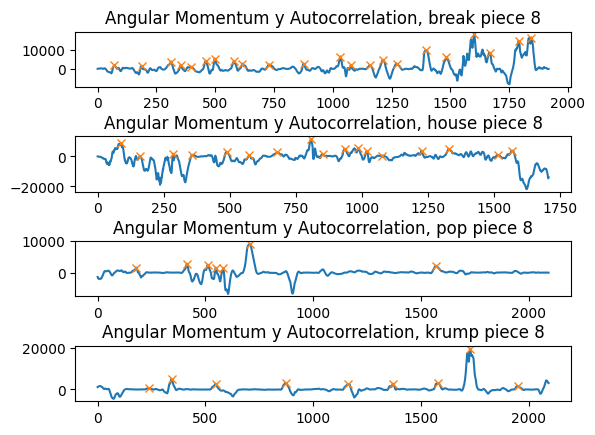

In [18]:
x1 = angmombr[:,1]
x2 = angmomho[:,1]
x3 = angmompo[:,1]
x4 = angmomkr[:,1]

#find the first peak angular momentum y-dimension. Then divide by frame number of that peak.
peaksbr, propertiesbr = find_peaks(x1, prominence=2100, height=0, distance=30, width=10)
peaksbr1 = peaksbr[0]
peaksho, propertiesho = find_peaks(x2, prominence=2100, height=0, distance=30, width=10)
peaksho1 = peaksho[0]
peakspo, propertiespo = find_peaks(x3, prominence=2100, height=0, distance=30, width=10)
peakspo1 = peakspo[0]
peakskr, propertieskr = find_peaks(x4, prominence=2100, height=0, distance=30, width=10)
peakskr1 = peakskr[0]

#plot
fig, ax = plt.subplots(4, 1)
ax[0].plot(x1)
ax[0].plot(peaksbr, x1[peaksbr], "x")
ax[0].set_title('Angular Momentum y Autocorrelation, break piece 8')
ax[1].plot(x2)
ax[1].plot(peaksho, x2[peaksho], "x")
ax[1].set_title('Angular Momentum y Autocorrelation, house piece 8')
ax[2].plot(x3)
ax[2].plot(peakspo, x3[peakspo], "x")
ax[2].set_title('Angular Momentum y Autocorrelation, pop piece 8')
ax[3].plot(x4)
ax[3].plot(peakskr, x4[peakskr], "x")
ax[3].set_title('Angular Momentum y Autocorrelation, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()

In [21]:
len(peaksbr) / len(x1)

0.011464304325169358

In [22]:
len(peaksho) / len(x2)

0.00996483001172333

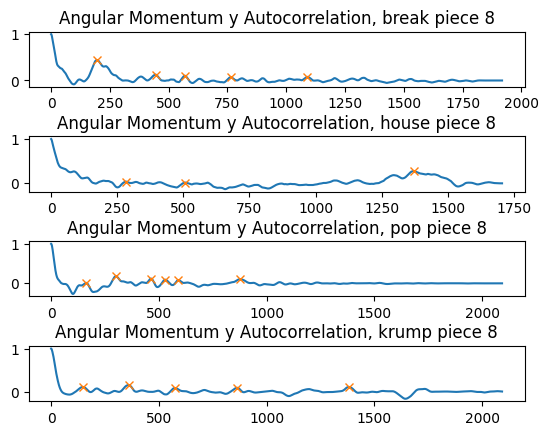

In [23]:
#angular momentum autocorrelation, y-dimension, for a break, house, pop, and krump piece. Four separate figures
x1 = np.correlate(angmombr[:,1], angmombr[:,1], mode='full')
x1 = x1[len(x1)//2:] #take only positive lags
x1 = x1 / x1[0] #normalize

x2 = np.correlate(angmomho[:,1], angmomho[:,1], mode='full')
x2 = x2[len(x2)//2:] #take only positive lags
x2 = x2 / x2[0] #normalize

x3 = np.correlate(angmompo[:,1], angmompo[:,1], mode='full')
x3 = x3[len(x3)//2:] #take only positive lags
x3 = x3 / x3[0] #normalize

x4 = np.correlate(angmomkr[:,1], angmomkr[:,1], mode='full')
x4 = x4[len(x4)//2:] #take only positive lags
x4 = x4 / x4[0] #normalize

#find the first peak angular momentum autocorrelation y-dimension. Then divide by frame number of that peak.
peaksbr, propertiesbr = find_peaks(x1, prominence=.1, height=0, distance=30, width=10)
peaksbr1 = peaksbr[0]
peaksho, propertiesho = find_peaks(x2, prominence=.1, height=0, distance=30, width=10)
peaksho1 = peaksho[0]
peakspo, propertiespo = find_peaks(x3, prominence=.1, height=0, distance=30, width=10)
peakspo1 = peakspo[0]
peakskr, propertieskr = find_peaks(x4, prominence=.1, height=0, distance=30, width=10)
peakskr1 = peakskr[0]

#plot
fig, ax = plt.subplots(4, 1)
ax[0].plot(x1)
ax[0].plot(peaksbr, x1[peaksbr], "x")
ax[0].set_title('Angular Momentum y Autocorrelation, break piece 8')
ax[1].plot(x2)
ax[1].plot(peaksho, x2[peaksho], "x")
ax[1].set_title('Angular Momentum y Autocorrelation, house piece 8')
ax[2].plot(x3)
ax[2].plot(peakspo, x3[peakspo], "x")
ax[2].set_title('Angular Momentum y Autocorrelation, pop piece 8')
ax[3].plot(x4)
ax[3].plot(peakskr, x4[peakskr], "x")
ax[3].set_title('Angular Momentum y Autocorrelation, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()



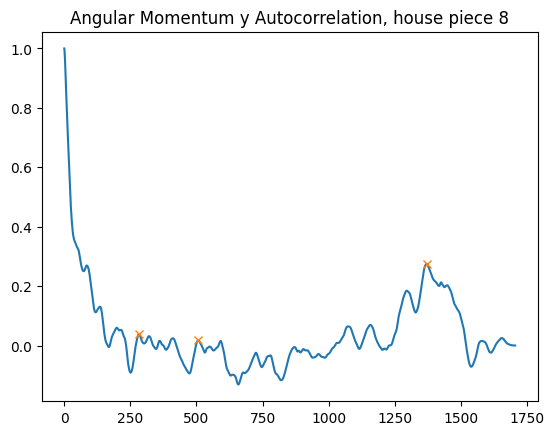

In [49]:
#plot peaksbr on top of x2
fig, ax = plt.subplots(1, 1)
ax.plot(x2)
ax.plot(peaksho, x2[peaksho], "x")
ax.set_title('Angular Momentum y Autocorrelation, house piece 8')
plt.show()

In [51]:
#find value of first peak in peaksho
peak1ho = x2[peaksho1]
#find value of thehighest peak in peaksho
peakmaxho = x2[peaksho].max()
#find the ratio of the first peak to the highest peak
peakratioho = peak1ho / peakmaxho
#multiply peakratio by the absolute value of number of frames between the first peak and the highest peak, plus one
peaktimeho = peakratioho * (abs(peaksho1 - peaksho.max()) + 1)
#divide by the number of frames in the piece
peaktimeho = peaktimeho / len(x2)

print(peak1ho, peakmaxho, peaktimeho)


0.038968142000029085 0.27518772091685595 0.09039189696837918


In [52]:
#find the prominence of the first peak in peaksho
peakpromho = propertiesho["prominences"][0]
#find the prominence of the highest peak in peaksho
peakprommaxho = propertiesho["prominences"].max()
#find the ratio of the first peak prominence to the highest peak prominence
peakpromratioho = peakpromho / peakprommaxho
#multiply peakpromratio by the absolute value of number of frames between the first peak and the highest peak, plus one
peakpromtimeho = peakpromratioho * (abs(peaksho1 - peaksho.max()) + 1)
#divide by the number of frames in the piece
peakpromtimeho = peakpromtimeho / len(x2)

print(peakpromho, peakprommaxho, peakpromtimeho)

0.13034946101608674 0.3465738114548544 0.24008352012402245


In [ ]:
#create a filter with the shape of the plot between 0 and the first peak
filter1 = np.zeros_like(x1)
filter1[0:peaks[0]] = 1

#bin the piece into bins the width of the filter
#then measure the correlation of each bin with the filter and sum the correlations
#then divide by the number of bins
#then divide by the number of frames in the piece




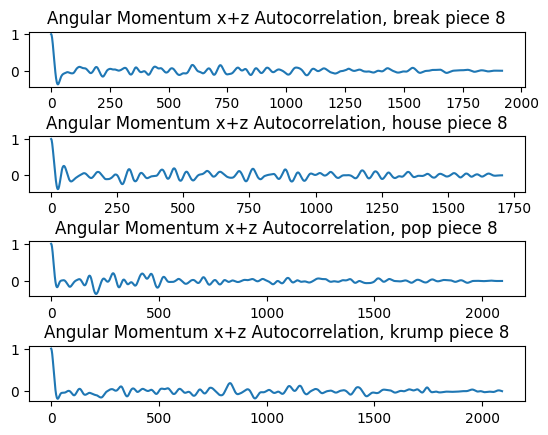

In [13]:
#angular momentum autocorrelation, x-dimension + z-dimension, for a break, house, pop, and krump piece. Four separate figures
x1 = np.correlate(angmombr[:,0] + angmombr[:,2], angmombr[:,0] + angmombr[:,2], mode='full')
x1 = x1[len(x1)//2:] #take only positive lags 
x1 = x1 / x1[0] #normalize

x2 = np.correlate(angmomho[:,0] + angmomho[:,2], angmomho[:,0] + angmomho[:,2], mode='full')
x2 = x2[len(x2)//2:] #take only positive lags
x2 = x2 / x2[0] #normalize

x3 = np.correlate(angmompo[:,0] + angmompo[:,2], angmompo[:,0] + angmompo[:,2], mode='full')
x3 = x3[len(x3)//2:] #take only positive lags
x3 = x3 / x3[0] #normalize

x4 = np.correlate(angmomkr[:,0] + angmomkr[:,2], angmomkr[:,0] + angmomkr[:,2], mode='full')
x4 = x4[len(x4)//2:] #take only positive lags
x4 = x4 / x4[0] #normalize

fig, ax = plt.subplots(4, 1)
ax[0].plot(x1)
ax[0].set_title('Angular Momentum x+z Autocorrelation, break piece 8')
ax[1].plot(x2)
ax[1].set_title('Angular Momentum x+z Autocorrelation, house piece 8')
ax[2].plot(x3)
ax[2].set_title('Angular Momentum x+z Autocorrelation, pop piece 8')
ax[3].plot(x4)
ax[3].set_title('Angular Momentum x+z Autocorrelation, krump piece 8')
#create virtual space between subplots
fig.subplots_adjust(hspace=0.9)
plt.show()


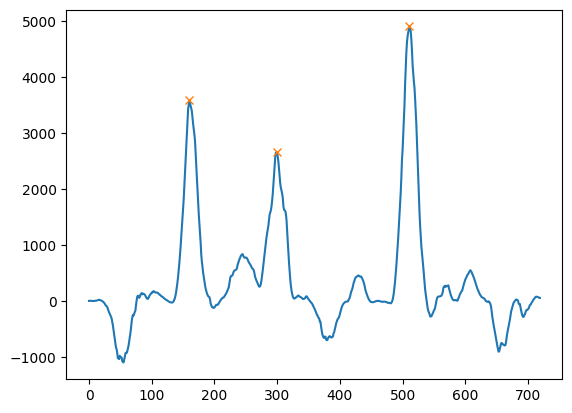

In [33]:
#find peaks in normalized angular momentum y
peaks, properties = find_peaks(angmom1[:,1], height=0, distance=30, prominence=1000, width=10)
plt.plot(angmom1[:,1])
plt.plot(peaks, angmom1[:,1][peaks], "x")
plt.show()

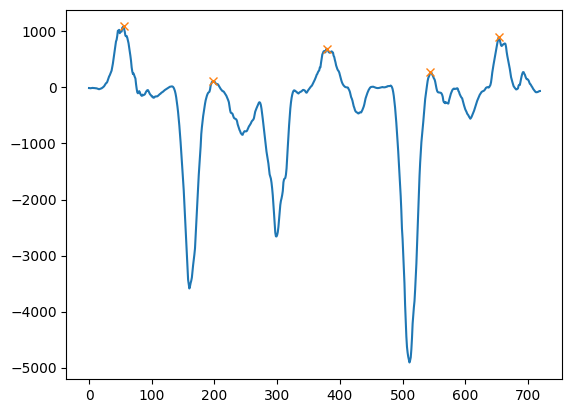

In [36]:
#find anti-peaks in normalized angular momentum y
apeaks, aproperties = find_peaks(-angmom1[:,1], height=0, distance=30, prominence=500, width=10)
plt.plot(-angmom1[:,1])
plt.plot(apeaks, -angmom1[:,1][apeaks], "x")
plt.show()


In [22]:
#peak widths
aproperties['prominences']

array([1120.15576893, 2774.04814366, 4279.41934317])

In [ ]:
#find x value of highest peak
maxpeak = np.argmax(angmom[:,1])
#find how many peaks are before the highest peak
numpeakspre = np.sum(peaks < maxpeak)
#find how many peaks are after the highest peak
numpeakspost = np.sum(peaks > maxpeak)

print(numpeakspre - numpeakspost)


In [127]:
len(peaks) + len(apeaks) / len(angmom[:,1])

18.006254343293953

In [11]:
bjazzdance1 = Dance(bjazzdata[3], 1/60)
bjazzdance1.get_movedata()
bjazzaccel = bjazzdance1.movedata[2]
bjazzdance1.get_sacrum()


In [12]:
breakaccel[10].shape

(2302, 3)

In [13]:
#inspect index error bjazz pieces
bjazz_errs = [Dance(err1[0], 1/60), Dance(err2[0], 1/60), Dance(err3[0], 1/60)]
[i.get_movedata() for i in bjazz_errs]
err1accel = bjazz_errs[0].movedata[2]

In [14]:
err1accel.shape

(15, 443, 3)

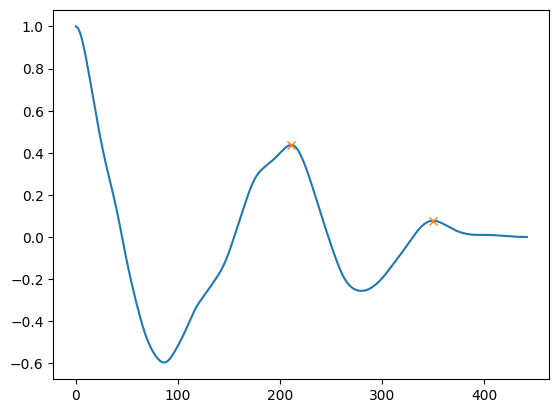

In [15]:
x = np.correlate(err1accel[4].T[0], err1accel[4].T[0], mode='full')
x = x[x.size//2:]
x = x / x[0]
plt.plot(x)
peaks, properties = find_peaks(x, height=0, distance=30, prominence=0.001)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [20]:
peaks

array([211, 350])

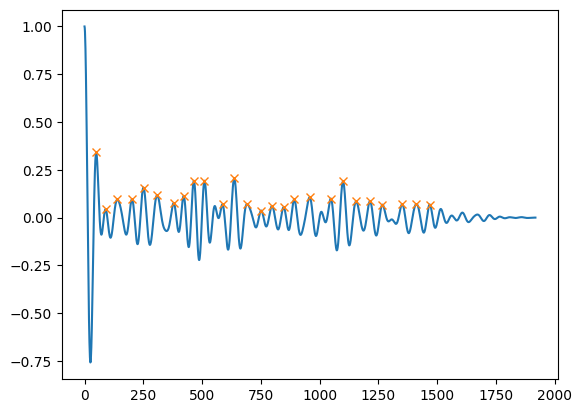

In [11]:


x = np.correlate(bjazzaccel[0].T[1], bjazzaccel[0].T[1], mode='full')
x.shape
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
plt.plot(x)
peaks, properties = find_peaks(x, height=0, distance=30, prominence=0.08)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [14]:
#peaks x positions
properties['peak_heights']


array([0.34085076, 0.04386799, 0.09492817, 0.09690103, 0.15719045,
       0.11833785, 0.07641862, 0.1133635 , 0.19254143, 0.19269265,
       0.0698683 , 0.20586915, 0.07154409, 0.03679318, 0.06085106,
       0.05426332, 0.09499813, 0.10601638, 0.09935548, 0.18989627,
       0.08504959, 0.08626254, 0.0677309 , 0.07017236, 0.07124305,
       0.06842627])

In [20]:
#find the index of the highest 4 peaks
peakstop = peaks[np.argsort(properties['peak_heights'])[-4:][::-1]]
peakstop / len(x)

array([0.02605524, 0.33194372, 0.26576342, 0.24231371])

In [21]:
#get the prominence of the highest 4 peaks
properties['prominences'][np.argsort(properties['peak_heights'])[-4:][::-1]]

array([0.56293167, 0.37713458, 0.36034545, 0.34679345])

In [29]:
#get prominence top three peaks, multiplied by the peak's x position
prominence = properties['prominences']
prominence = prominence * peaks
prominence = np.sort(prominence)
prominence = prominence[::-1]
prominence = prominence[:3]
print(prominence)


[239.29017245 234.99886492 161.84502879]


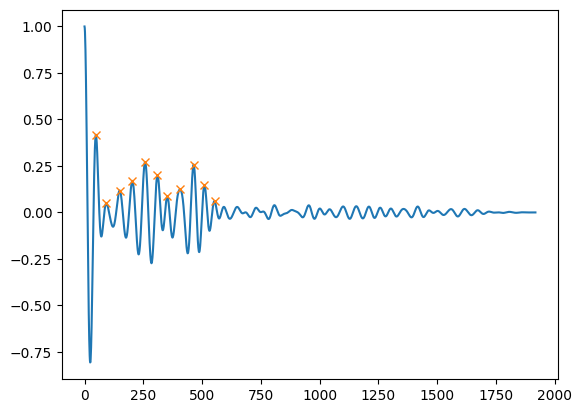

In [25]:


x = np.correlate(bjazzdance1.sacrum[2].T[1], bjazzdance1.sacrum[2].T[1], mode='full') 
#+ np.correlate(bjazzdance1.sacrum[2].T[2], bjazzdance1.sacrum[2].T[2], mode='full')) / 2
x.shape
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
plt.plot(x)
peaks, properties = find_peaks(x, height=0, distance=10, prominence=0.08)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [35]:
#maybe do highest peak times frame/length

[0.26179117 0.10120351 0.32066668 0.19691281 0.18234192 0.31961091
 0.13887742 0.23604483 0.17438431 0.24101943 0.19038167 0.17077296
 0.21209868 0.11148271 0.10073082 0.13726837 0.08246987 0.16234355
 0.09382238 0.18230291 0.1030213  0.08276605 0.08359042]


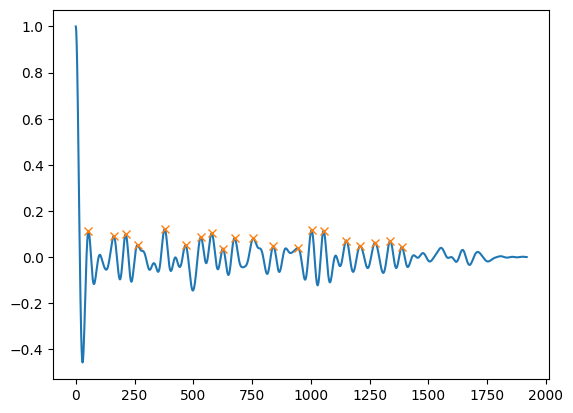

In [28]:
x = (np.correlate(bjazzaccel[10].T[0], bjazzaccel[10].T[0], mode='full')
+ np.correlate(bjazzaccel[9].T[0], bjazzaccel[9].T[0], mode='full')) / 2
x.shape
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
plt.plot(x)
peaks, properties = find_peaks(x, height=0, distance=30, prominence=0.08)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [47]:
properties['peak_heights'].std()/len(properties['peak_heights'])

4.147228367982887

In [54]:
x = np.cov(bjazzaccel[9].T[2], bjazzaccel[5].T[2])
print(x)
x = x[x.size//2:] #take only positive lags
# = x / x[0] #normalize
#plt.plot(x)
#peaks, properties = find_peaks(x, height=0, distance=30, prominence=0.08)
#plt.plot(peaks, x[peaks], "x")
#plt.show()

[[ 18008.58608545  44512.5369822 ]
 [ 44512.5369822  173765.97184333]]


In [77]:
breakvel0 = np.diff(breakdata[4][8].T[0])  
print(breakvel0.shape)
breakacc0 = np.diff(breakvel0)
print(breakacc0.shape)
housevel0 = np.diff(housedata[4][8].T[0])
houseacc0 = np.diff(housevel0)
print(housevel0.shape)
popvel0 = np.diff(popdata[4][8].T[0])
popacc0 = np.diff(popvel0)


(2301,)
(2300,)
(1770,)


In [78]:
from scipy import signal
from scipy.signal import find_peaks
for d in housedata:
    for j in range(len(housedata[0])):
        #find out if there are no peaks in the autocorrelation of each joint with left wrist, idx = 7
        #if there are no peaks, then something may be off
        x = np.correlate(d[j].T[0], d[8].T[0], mode='full')
        x = x[x.size//2:] #take only positive lags
        x = x / x[0] #normalize

        peaks, _ = find_peaks(x, prominence=.05, distance=30)
        if len(peaks) == 0:
            print('no peaks in autocorrelation of joint', j, 'with right wrist')
        



no peaks in autocorrelation of joint 0 with right wrist
no peaks in autocorrelation of joint 1 with right wrist
no peaks in autocorrelation of joint 2 with right wrist
no peaks in autocorrelation of joint 3 with right wrist
no peaks in autocorrelation of joint 4 with right wrist
no peaks in autocorrelation of joint 5 with right wrist
no peaks in autocorrelation of joint 7 with right wrist
no peaks in autocorrelation of joint 9 with right wrist
no peaks in autocorrelation of joint 10 with right wrist
no peaks in autocorrelation of joint 11 with right wrist
no peaks in autocorrelation of joint 12 with right wrist
no peaks in autocorrelation of joint 13 with right wrist
no peaks in autocorrelation of joint 14 with right wrist


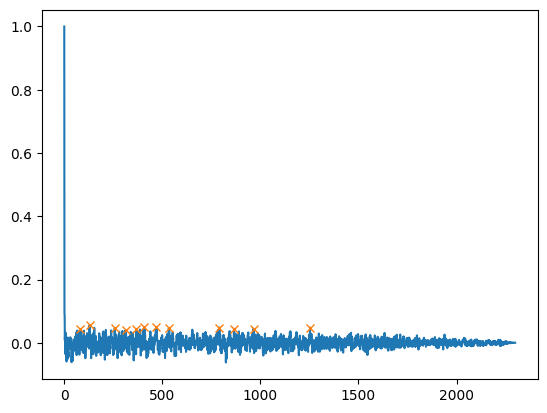

In [62]:
#find peaks, leftbases and rightbases in autocorrelation coefficients
peaks, properties = find_peaks(x, prominence=.08, distance=30) #
#plot peaks on autocorrelation coefficients
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [63]:
properties['prominences']

array([0.09267544, 0.11704896, 0.09843696, 0.08886978, 0.08334547,
       0.10485488, 0.09689043, 0.08785723, 0.09652603, 0.08242547,
       0.08495366, 0.08680487])

In [65]:
properties

{'prominences': array([0.09267544, 0.11704896, 0.09843696, 0.08886978, 0.08334547,
        0.10485488, 0.09689043, 0.08785723, 0.09652603, 0.08242547,
        0.08495366, 0.08680487]),
 'left_bases': array([ 37,  37, 207, 272, 354, 354, 420, 514, 514, 824, 824, 824]),
 'right_bases': array([ 107,  824,  354,  354,  390,  824,  824,  563,  824,  896, 1015,
        1546])}

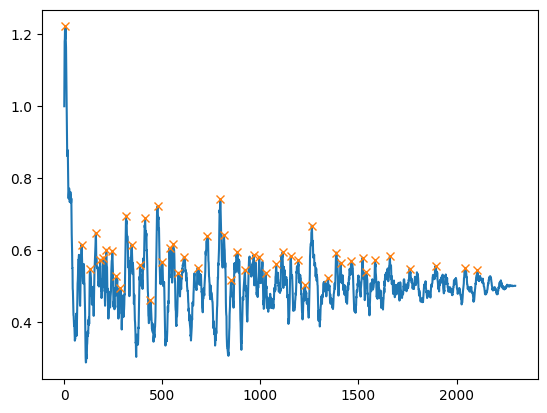

In [34]:
#positive integral of autocorrelation coefficients
posint = np.cumsum(x)
#plot positive integral of autocorrelation coefficients
plt.plot(posint)

ppeaks, _ = find_peaks(posint, prominence=.06, distance=15) #
plt.plot(ppeaks, posint[ppeaks], "x")
plt.show()

In [26]:
#5 features: spacing approximates inverse of density+locality, std*len(x) approximates variance, 
# len(ppeaks) approximates number of peaks, hit apporximates first/second movement self-similarity 
spacing = np.log((len(x) * peaks[-2]) / len(peaks))
onehit = (posint[ppeaks[0]] - posint[ppeaks].mean()) 
twohit = (posint[ppeaks[1]] - posint[ppeaks].mean()) 
print(spacing, x.std()*len(x), len(ppeaks), onehit, twohit)

11.791504196209324 62.53271082112763 52 1.2837507540212378 -0.1609543905479654


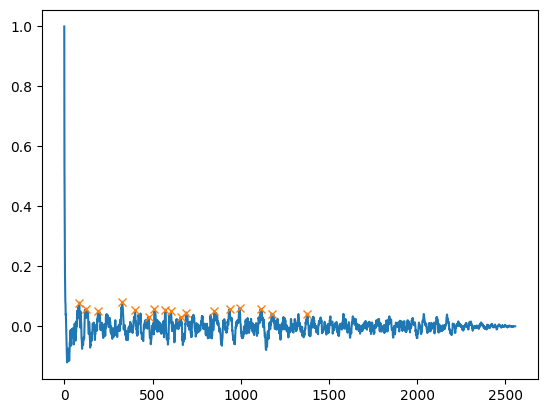

In [35]:
#find and plot autocorrelation of popdata[0][13]
x = np.correlate(popacc0, popacc0, mode='full')
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
#find peaks,  in autocorrelation coefficients
peaks, _ = find_peaks(x, prominence=.08, distance=30) #
#plot peaks on autocorrelation coefficients
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

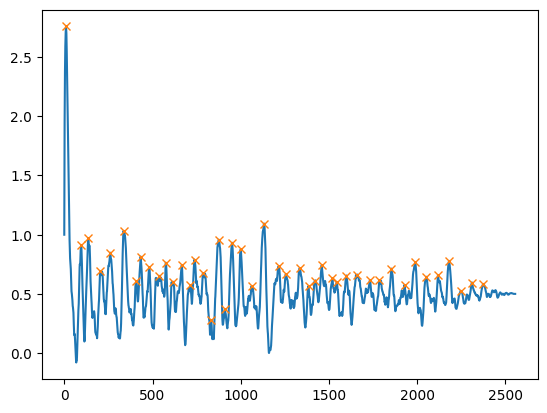

In [36]:
#positive integral of autocorrelation coefficients
posint = np.cumsum(x)
#plot positive integral of autocorrelation coefficients
plt.plot(posint)

ppeaks, _ = find_peaks(posint, prominence=.08, distance=15) #
plt.plot(ppeaks, posint[ppeaks], "x")
plt.show()

In [15]:
ppeaks[1]

51

In [37]:
#5 features: spacing approximates inverse of density+locality, std*len(x) approximates variance, 
# len(ppeaks) approximates number of peaks, hit apporximates first/second movement self-similarity 
spacing = np.log((len(x) * peaks[-1]) / len(peaks))
onehit = (posint[ppeaks[0]] - posint[ppeaks].mean()) 
twohit = (posint[ppeaks[1]] - posint[ppeaks].mean()) 
print(spacing, x.std()*len(x), len(ppeaks), onehit, twohit)

12.239194481541881 85.98555222078706 44 2.008830764559256 0.1644530345544002


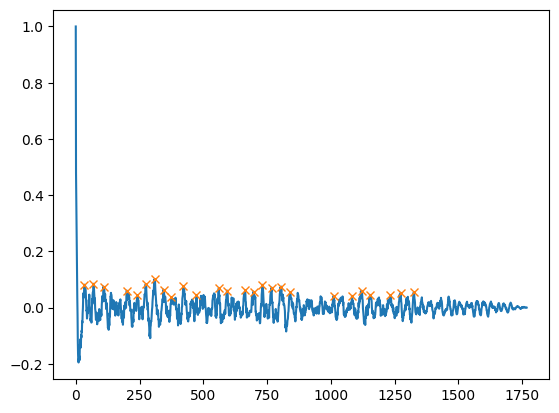

In [79]:
#find and plot autocorrelation of housedata[0][13]
x = np.correlate(houseacc0, houseacc0, mode='full')
x = x[x.size//2:] #take only positive lags
x = x / x[0] #normalize
#find peaks, leftbases and rightbases in autocorrelation coefficients
peaks, _ = find_peaks(x, prominence=.08, distance=30) #
#plot peaks on autocorrelation coefficients
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

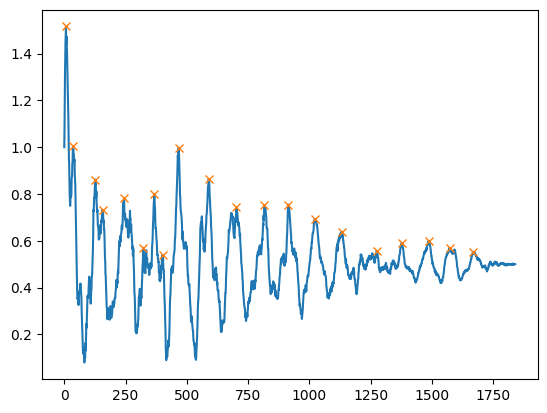

In [18]:
#positive integral of autocorrelation coefficients
posint = np.cumsum(x)
#plot positive integral of autocorrelation coefficients
plt.plot(posint)

ppeaks, _ = find_peaks(posint, prominence=.08, distance=30) #
plt.plot(ppeaks, posint[ppeaks], "x")
plt.show()

In [19]:
#5 features: spacing approximates inverse of density+locality, std*len(x) approximates variance, 
# len(ppeaks) approximates number of peaks, hit apporximates first/second movement self-similarity 
spacing = np.log((len(x) * peaks[-1]) / len(peaks))
onehit = (posint[ppeaks[0]] - posint[ppeaks].mean()) 
twohit = (posint[ppeaks[1]] - posint[ppeaks].mean()) 
print(spacing, x.std()*len(x), len(ppeaks), onehit, twohit)

11.822813691045523 55.37363498794805 20 0.7599460462452241 0.24808528887925752


In [20]:
def get_joint_corr(dance, joint1, joint2, dim, prominence=.08, distance=30):
    vel1 = np.diff(dance[joint1].T[dim])
    vel2 = np.diff(dance[joint2].T[dim])
    accel1 = np.diff(vel1)
    accel2 = np.diff(vel2)
    
    x = np.correlate(accel1, accel2, mode='full')
    x = x[x.size//2:] #take only positive lags
    x = x / x[0] #normalize

    peaks, _ = find_peaks(x, prominence=prominence, distance=distance)
    posint = np.cumsum(x)
    ppeaks, _ = find_peaks(posint, prominence=prominence, distance=distance)
    spacing = len(peaks)**2 / (peaks[-1])
    deviate = np.std(x[peaks])
    onehit = (posint[ppeaks[0]] - posint[ppeaks].mean())
    twohit = (posint[ppeaks[1]] - posint[ppeaks].mean())

    return spacing, deviate, onehit, twohit

a,b,c,d = get_joint_corr(popdata[3], 7, 8, 0)
print('spacing =', a)
print('deviate =', b)
print('onehit =', c)
print('twohit =', d)
    

spacing = 0.852863436123348
deviate = 0.3484148442104291
onehit = 22.802656305236646
twohit = 9.007718772973353


In [21]:
breakdata[3].shape

(15, 2093, 3)

17.98577894424201
5.348464900048569


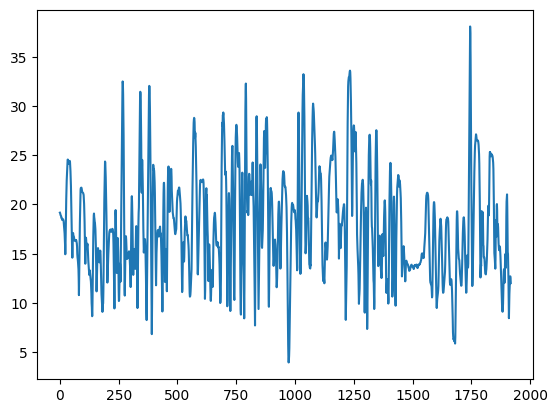

In [22]:
lankle = housedata[0][13]
rankle = housedata[0][14]
#plot difference between left and right ankle
footwidth = np.abs(lankle - rankle).mean(axis=1)
plt.plot(footwidth)
print(footwidth.mean())
print(footwidth.std())

In [ ]:
lankle = breakdata[0][13]
rankle = breakdata[0][14]
#plot difference between left and right ankle
footwidth = np.abs(lankle - rankle).mean(axis=1)
plt.plot((footwidth - footwidth.mean())/footwidth.std())
print(footwidth.mean())
print(footwidth.std())

